This notebook is a practice from hand-on ml by handson


I work some experiment with simplified code and leave notes

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import tarfile
import pandas as pd
from six.moves import urllib
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The difference between "simple random split" and 'stratified split' is that the later one perserves the population distribution of overall population and then avoid bias. We do a simple test on "income median" cat to demostration the different.

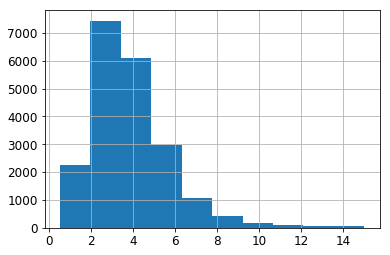

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
housing.median_income.hist()

In [36]:
#catagorize into 5 group and merge extreme value to cat5
housing['income_cat'] = np.ceil(housing['median_income']/1.5)
housing['income_cat'].where(housing.median_income < 5, 5, inplace=True)
train_rand, test_rand = train_test_split(housing,test_size=0.2,random_state=42) #random shuffle
strata_split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42) #strata shuffle
for train_index, test_index in strata_split.split(housing, housing.income_cat):
    train_strata = housing.loc[train_index]
    test_index = housing.loc[test_index]
overall = housing.income_cat.value_counts().rename('overall')/len(housing)
rand = train_rand.income_cat.value_counts().rename('rand')/len(train_rand)
strata = train_strata.income_cat.value_counts().rename('strata')/len(train_strata)
pd.concat([overall,rand,strata],axis=1).sort_index()

,overall,rand,strata
1.0,0.039826,0.039729,0.039850
2.0,0.318847,0.317466,0.318859
3.0,0.350581,0.348595,0.350594
4.0,0.072287,0.072735,0.072250
5.0,0.218459,0.221475,0.218447


Using Geoinfo to visulize and capture the big picture. The plot shows that the price is highly correlated to location. This gives us a great idea to add new feature to discribe distance from cluster centre.

Saving figure housing_prices_scatterplot


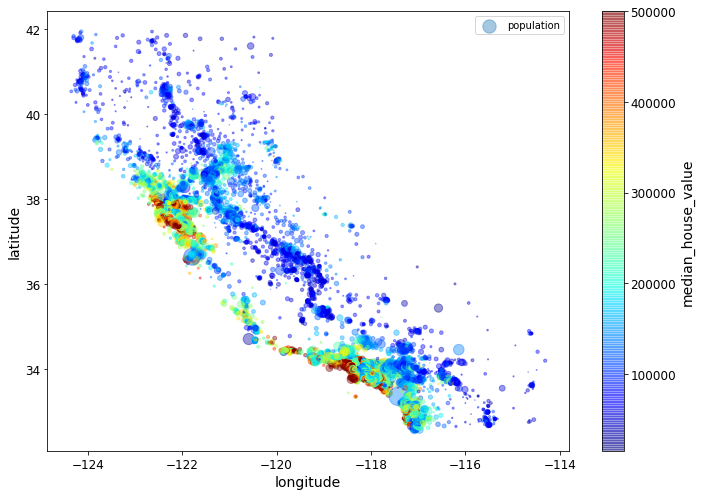

In [38]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [42]:
# See the correlation
housing.corr()['median_house_value'].sort_values(ascending=0)

median_house_value    1.000000
median_income         0.688075
income_cat            0.621421
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

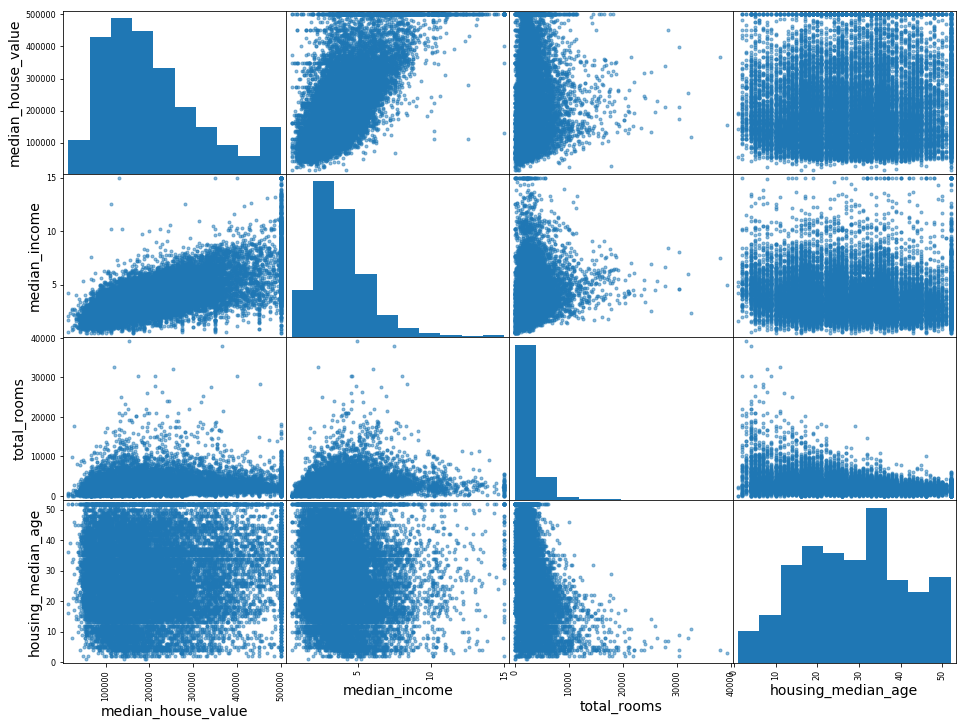

In [53]:
# Correlation map by maplotlib
from pandas.tools.plotting import scatter_matrix
cols = housing.columns[[-3,-4,3,2]]
scm = scatter_matrix(housing[cols],figsize=(16,12),alpha=0.5)

Now we try to make some beautiful plot via seaborn 

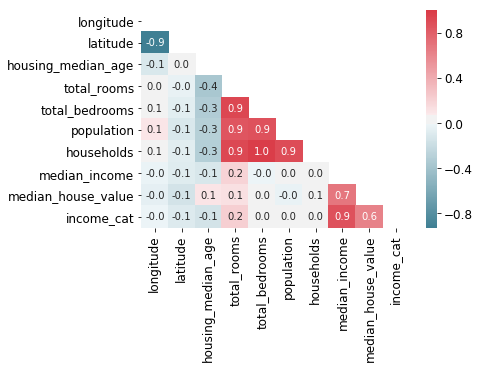

In [71]:
import seaborn as sns
corr = housing.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
heatmap = sns.heatmap(corr,mask=mask,cmap=cmap,square=False,annot=True,fmt='1.1f')

Now we do data cleaning before we head to ml alogrithm

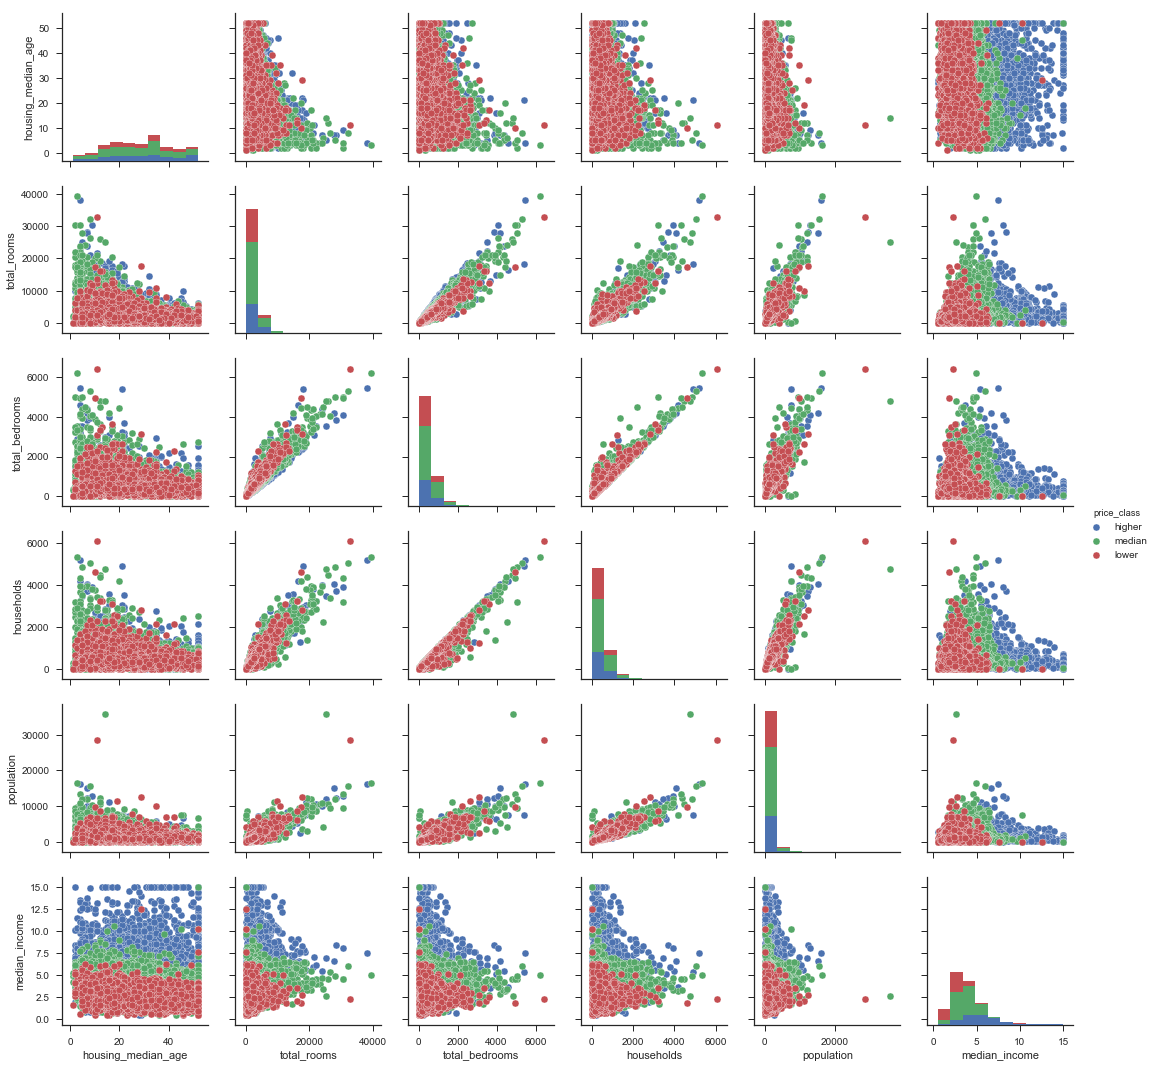

In [131]:
c = housing.median_house_value.quantile([.25,.5,.75]).values
def class_convert(x,c):
    if x <= c[0]: return 'lower'
    elif (x > c[0]) and (x<=c[2]): return 'median'
    else: return 'higher'
housing['price_class'] = housing.median_house_value.apply(class_convert,args=(c,))
cols = ['housing_median_age','total_rooms','total_bedrooms','households','population','median_income','price_class']
sns.pairplot(housing[cols].dropna(), hue='price_class')